In [1]:
! python -m numpy.f2py -c montecarlo.f90 -m montecarlo

running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "montecarlo" sources
f2py options: []
f2py:> /var/folders/q1/8h226kws6qj8hctylvlyybhh0000gn/T/tmppq29qpzo/src.macosx-10.7-x86_64-3.7/montecarlomodule.c
creating /var/folders/q1/8h226kws6qj8hctylvlyybhh0000gn/T/tmppq29qpzo/src.macosx-10.7-x86_64-3.7
Reading fortran codes...
	Reading file 'montecarlo.f90' (format:free)
Line #14 in montecarlo.f90:"        intent(in,out), DIMENSION(mx,my) :: ms"
	analyzeline: cannot handle multiple attributes without type specification. Ignoring ' dimension(mx,my)'.
Line #16 in montecarlo.f90:"        intent(in,out), DIMENSION(mx,my) :: icount"
	analyzeline: cannot handle multiple attributes without type specification. Ignoring ' dimension(mx,my)'.
Line #19 in montecarlo.f90:"        intent(in,o

In [2]:
import numpy as np
import random as rand
import matplotlib.pyplot as plt
import scipy
import math
import time
import montecarlo as mcmc
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
# Make the plots a bit bigger to see
# NOTE: Must be done in a separate cell
plt.rcParams['figure.dpi'] = 100

In [4]:
#### uncomment to veiw the details of fortran subroutines used ####
# print(mcmc.hb_loop.__doc__)
# print(mcmc.dfree.__doc__)
# print(mcmc.dgrad2.__doc__)

In [5]:
#### parameters for simulations ####
parameter = {
    'mx': 64,
    'my': 64,
    'nwarm':200000,
    'nskip':4000,
    'Tc':1.0,
    'coef':0.1,
    'dphi':0.2,
    'gamma':0.05,
    'r0':2.0,
    'Rload':0.5
}


In [6]:
class Ginz_Landau_FE:
    def __init__(self,parameter,E,Tb,phi,seed):
        self.parameter = parameter
        for iparam,param in parameter.items():
            setattr(self, iparam, parameter[iparam])
        self.nskip = self.nskip*self.mx*self.my
        self.E = E                                 ## Electric Field added as an input
        self.Tb = Tb                               ## Bath Temperature
        self.phi = phi                             ## Order parameter lattice
        self.ms = np.ones((self.mx,self.my))       ## Mean Field order parameter (to determine Teff)
        self.v0 = np.zeros((self.mx,self.my))  
        self.phi_new = np.zeros((self.mx,self.my)) ## Copy of order parameter (may be commented out)
#         self.v0 = disorder*np.random.rand((mx,my)) 
        self.Teff = self.Tb*np.ones((self.mx,self.my)) ## Effective Temperature of the lattice
        self.dx = 1.0      ## Step along X-axis
        self.dy = 1.0      ## Step along Y-axis
        self.Lx = self.dx*(float(self.mx))  ## Length of sample
        self.Ly = self.dy*(float(self.my))  ## Breadth of sample
        self.volt = self.E*self.Ly          ## Volatge bais 
        self.eq_flag = True     ## Flag for equilibriation True --> Warming , False --> Measurement
        self.seed = seed    ## Random Seed
    
    ## Compute Gradient of any 2x2 array (periodic along X, but not Y)
    def gradient(self,f):
        du = np.zeros((self.mx,self.my))
        du[1:-1,0:] += ( (f[2:,0:] - f[1:-1,0:]) /self.dx)**2 + ((f[0:-2,0:] - f[1:-1,0:])/self.dx)**2 
        du[:,1:-1] += ((f[:,2:] - f[:,1:-1])/self.dy)**2 + ((f[:,0:-2] - f[:,1:-1])/self.dy)**2 
        du[0,:] += ((f[1,:] - f[0,:])/self.dx)**2 + ((f[-1,:] - f[0,:])/self.dx)**2
        du[-1,:] += ((f[0,0:] - f[-1,0:])/self.dx)**2 + ((f[-2,0:] - f[-1,0:])/self.dx)**2
        du[:,0] += ((f[:,1] - f[:,0])/self.dy)**2
        du[:,-1] += ((f[:,-2] - f[:,-1])/self.dy)**2
        return du

    ## Local Gradient (not used)
    def grad_phi(self,phi_loc,i,j):
        i1 = (i-1+self.mx)%self.mx
        i2 = (i+1)%self.mx
        dg = ((self.phi[i2,j] - phi_loc)/self.dx)**2 + ((self.phi[i1,j]-phi_loc)/self.dx)**2 
        if j > 0 :
            dg += ((self.phi[i,j-1]-phi_loc)/self.dy)**2
        if j < (self.my-1):
            dg += ((self.phi[i,j+1]-phi_loc)/self.dy)**2    
        return dg

    ## Compute Free Energy as an array (not used)
    def free_energy(self):
        term1 = 0.5*((self.Teff/self.Tc) - 1.0)*self.phi**2 
        term2 = 0.5*self.r0*self.gradient(self.phi)
        term3 = 0.25*self.phi**4
        fe = term1 + term2 + term3
        return fe*self.dx*self.dy
    
    ## Local Free Energy computation (Not used but may be used)
#     def local_fe(self, phi_loc, Teff_loc, i, j):
#         self.phi_new = self.phi_new + self.phi
#         self.phi_new[i,j] = phi_loc
#         del_phi = self.gradient(self.phi_new)
#         fij = 0.5*((Teff_loc/self.Tc) - 1.0)*phi_loc**2 + 0.25*phi_loc**4 + 0.5*self.r0*self.grad_phi(phi_loc,i,j) 
#         self.phi_new = np.zeros((self.mx,self.my))
#         return fij*self.dx*self.dy
    
    ## Calculating Energy difference between two points on the lattice
    def dfree(self,phi1,Teff1,i,j):
        df = -0.5*(phi1**2-self.phi[i,j]**2) + 0.25*(phi1**4-self.phi[i,j]**4)
        df += 0.5*self.r0*(self.grad_phi(phi1,i,j) - self.grad_phi(self.phi[i,j],i,j)) 
        df += 0.5*Teff1/self.Tc*phi1**2 - 0.5*self.Teff[i,j]/self.Tc*self.phi[i,j]**2
        return df*self.dx*self.dy

    ## Monte Carlo Loop
    def heatbath_loop(self,f):
        ## set Random Seed
        np.random.seed(self.seed)
        self.seed += 4
        idummy = np.random.randint(1000000,10000000000)
        ncount = 0
        iflip = 0
        icount = np.zeros((self.mx,self.my),dtype=int,order='F')
        self.ms = self.ms*0.0
        ## set flag
        if(self.eq_flag):
            nstep = self.nwarm
        else:
            nstep = self.nskip 
        rate = 0  
        ## Monte Carlo loop : using fortran code montecarlo.f90
        self.phi, self.Teff, f, self.ms, icount, rate = mcmc.hb_loop(self.phi, self.Teff, f, self.ms, icount,
                                                                     nstep, self.dx, self.dy, idummy, self.Tc,
                                                                     self.Tb, self.dphi, self.r0, self.v0,
                                                                     self.mx,self.my)  
        
        self.ms = np.where(icount == 0, self.phi , self.ms/icount)        

        return self.phi, self.Teff, self.ms, f

    ## Compute Effective Temperature    
    def setTeff(self):
        tbath = self.Tb*np.ones((self.mx,self.my))
        gam = self.gamma*np.ones((self.mx,self.my))
        efield = self.coef*self.E*np.ones((self.mx,self.my))
        return np.sqrt(tbath**2 + efield**2/(gam**2 + self.ms**2) )
    
    ## Compute Averages
    def averages(self,f):
        ave_phi = np.mean(self.phi)
        ave_phi2 = np.mean(self.phi**2)
        std_phi2 = np.std(self.phi**2)
        ave_fe = f/(self.mx*self.my)
        std_fe = np.sqrt((f**2 - ave_fe**2)/(self.mx*self.my))
        ave_teff = np.mean(self.Teff)
        return std_fe, ave_phi, ave_fe, ave_teff, ave_phi2, std_phi2
    
    ## Function initiating the Warming of the lattice
    def warming(self):
        self.Teff = self.setTeff()
        f = np.sum(self.free_energy())
        self.phi, self.Teff, self.ms, f = self.heatbath_loop(f) 
        return self, f
    
    ## Function intiating the production runs and gives out the measurements
    def meas(self,f):
        self.eq_flag = False
        self.Teff = self.setTeff()
        f = np.sum(self.free_energy())
        self.phi, self.Teff, self.ms, f = self.heatbath_loop(f)
        std_fe, ave_phi, ave_fe, ave_teff, ave_phi2, std_phi2 = self.averages(f)
        ft = self.free_energy()
        return std_fe, ave_phi, ave_fe, ave_teff, ave_phi2, std_phi2, ft.flatten(), self.phi
        
    
           

In [7]:
start = time.time()
nmeas = 8 
print(parameter)
Mx = parameter["mx"]
My = parameter["my"]
Tbvals = np.arange(0.02,1.02,0.02)
Tbvals = np.append(Tbvals,Tbvals[::-1])
ndata = np.size(Tbvals)
print("Tbvals :",Tbvals)
E = 0.0
Data_Set = np.zeros((ndata,8))
k = 0
phit = np.ones((Mx,My))
# print(phit)
seed = 45467887
for Tb in Tbvals: 
    glt = Ginz_Landau_FE(parameter,E,Tb,phit,seed)
    fm = glt.warming()
    Data_Set[k,0] = Tb
    for i in range(0,nmeas):
        f2 , delta, f , teff , ohm, ohm2, ft, phit = glt.meas(fm)
        Data_Set[k,1:8] += [delta , ohm - delta**2 , f, f2 , ohm, ohm2, teff]
        
    Data_Set[k,1:8] = Data_Set[k,1:8]/nmeas
    print(Data_Set[k,:])    
    k += 1 
    seed += 1

np.savetxt("delta_f2py.dat",Data_Set)
time1 = time.time() - start
print(time1)

{'mx': 64, 'my': 64, 'nwarm': 200000, 'nskip': 4000, 'Tc': 1.0, 'coef': 0.1, 'dphi': 0.2, 'gamma': 0.05, 'r0': 2.0, 'Rload': 0.5}
Tbvals : [0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28
 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54 0.56
 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82 0.84
 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.   1.   0.98 0.96 0.94 0.92 0.9
 0.88 0.86 0.84 0.82 0.8  0.78 0.76 0.74 0.72 0.7  0.68 0.66 0.64 0.62
 0.6  0.58 0.56 0.54 0.52 0.5  0.48 0.46 0.44 0.42 0.4  0.38 0.36 0.34
 0.32 0.3  0.28 0.26 0.24 0.22 0.2  0.18 0.16 0.14 0.12 0.1  0.08 0.06
 0.04 0.02]
[ 2.00000000e-02  9.85953319e-01  2.58443260e-03 -2.22514045e-01
  1.42408985e+01  9.74691528e-01  1.00189721e-01  2.00000000e-02]
[ 4.00000000e-02  9.71300110e-01  5.25307415e-03 -1.95301600e-01
  1.24993020e+01  9.48678372e-01  1.40737691e-01  4.00000000e-02]
[ 6.00000000e-02  9.56060621e-01  8.02280070e-03 -1.67495105e-01
  1.07196864e+01  9.220864

[7.00000000e-01 4.04368266e-03 1.70912070e-01 6.65162084e-01
 4.25703721e+01 1.71126572e-01 2.26939113e-01 7.00000000e-01]
[6.80000000e-01 4.29769950e-03 1.65040242e-01 6.46354098e-01
 4.13666611e+01 1.65937393e-01 2.20834337e-01 6.80000000e-01]
[6.60000000e-01 2.75807754e-02 1.67388549e-01 6.21732201e-01
 3.97908597e+01 1.70558224e-01 2.26752522e-01 6.60000000e-01]
[6.40000000e-01 4.86202837e-03 1.65600728e-01 6.06500706e-01
 3.88160440e+01 1.68359436e-01 2.22615030e-01 6.40000000e-01]
[ 6.20000000e-01 -1.61151984e-02  1.72432194e-01  5.89969352e-01
  3.77580374e+01  1.73214516e-01  2.24969644e-01  6.20000000e-01]
[ 6.00000000e-01 -3.46059046e-02  1.66668059e-01  5.71691771e-01
  3.65882722e+01  1.69349959e-01  2.21576405e-01  6.00000000e-01]
[5.80000000e-01 1.03873230e-02 1.83089858e-01 5.48661035e-01
 3.51143052e+01 1.85092836e-01 2.38289650e-01 5.80000000e-01]
[5.60000000e-01 1.09654646e-02 1.81875278e-01 5.24496510e-01
 3.35677756e+01 1.93210990e-01 2.41131462e-01 5.60000000e-01]


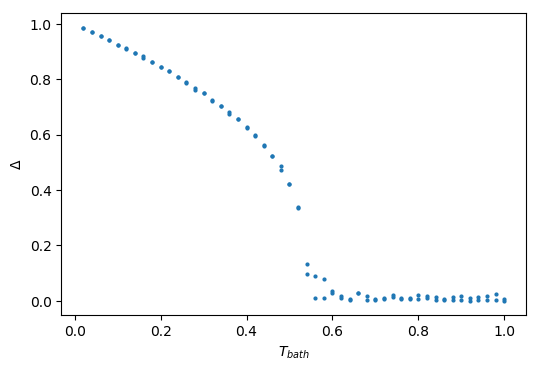

In [8]:
plt.scatter(Data_Set[:,0],np.abs(Data_Set[:,1]), s = 4.0)
# plt.plot(Data_Set[:,0],Data_Set[:,1])
plt.xlabel(r'$T_{bath}$')
plt.ylabel(r'$\Delta$')
# plt.xticks(np.arange(0, 1, step=0.1))
# plt.yticks(np.arange(-0.1, 1, step=0.1))
plt.show()

In [9]:
# hb_loop(phi,Teff,f,ms,icount,rate,nstep,dx,dy,idummy,Tc,Tbath,dphi,r0,v0,mx,my)

In [10]:
print(phit)

[[-1.00939303 -1.06233124 -0.96618794 ... -1.02617156 -0.96504179
  -1.00802419]
 [-1.05558022 -0.96707033 -0.9046543  ... -0.95902195 -0.93433862
  -0.95565216]
 [-1.06309688 -0.99719015 -0.92053233 ... -0.93446656 -0.94521581
  -0.96311693]
 ...
 [-1.06083654 -1.0389024  -0.94857554 ... -0.98155495 -0.96840807
  -1.01930998]
 [-1.08183458 -0.99242997 -0.966667   ... -0.99280261 -0.98280928
  -1.02665125]
 [-1.009311   -1.01081872 -1.02379045 ... -0.94286196 -0.93597319
  -1.0289459 ]]


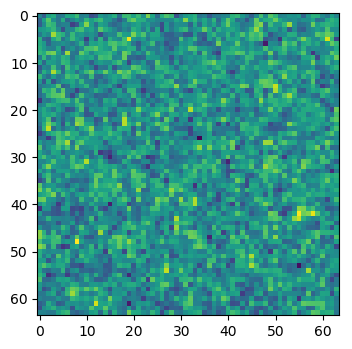

In [11]:
plt.imshow(phit)